# Install & Import Dependencies

In [1]:
! pip install lexical-diversity -q

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from collections import Counter
from lexical_diversity import lex_div as ld

# Loading Synthetic Data

## Training Dataset Social Services

In [3]:
# Path to your .txt file
file_path = '/kaggle/input/synthetic-data-social-services/synthetic-data-social-services.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    raw_data = file.read()

# Split the raw data into entries based on '\n\n'
entries = raw_data.strip().split('\n\n')

# Initialize lists to hold titles and contents
titles = []
contents = []

# Process each entry
for entry in entries:
    # Split each entry into title and content based on '\n'
    lines = entry.split('\n', 1)  # Split only on the first '\n'
    if len(lines) == 2:
        title, content = lines
        titles.append(title)
        contents.append(content)
    else:
        # Handle cases where the entry does not have a proper title/content split
        titles.append(lines[0])
        contents.append('')

# Create a DataFrame from the lists
df_train = pd.DataFrame({
    'title': titles,
    'content': contents
})

print(df_train.shape)

(230, 2)


## Manual Labeled Service Categories

In [4]:
# Path to your .txt file
file_path = '/kaggle/input/synthetic-data-social-services/synthetic-data-social-services-categories.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    raw_data = file.read()
    
# Repeat each term 10 times
df_train['category'] = [term for term in raw_data.split('\n') for _ in range(10)]

In [5]:
# Path to your .txt file
file_path = '/kaggle/input/synthetic-data-social-services/synthetic-data-press-releases.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    raw_data = file.read()

# Split the raw data into entries based on '\n\n'
entries = raw_data.strip().split('\n\n')

# Initialize lists to hold titles and contents
titles = [el.split('\n')[0] for el in entries[::2]]
contents = entries[1::2]

# Create a DataFrame from the lists
df_test = pd.DataFrame({
    'title': titles,
    'content': contents
})

print(df_test.shape)

(80, 2)


In [6]:
# Path to your .txt file
file_path = '/kaggle/input/synthetic-data-social-services/synthetic-data-non-service-texts.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    raw_data = file.read()
    
# Split the raw data into entries based on '\n\n'
entries = [el.split('\n') for el in raw_data.strip().split('\n\n')]

# Initialize lists to hold titles and contents
titles = [el[0] for el in entries]
contents = [el[1] for el in entries]

# Create a DataFrame from the lists
df_noise = pd.DataFrame({
    'title': titles,
    'content': contents
})

print(df_noise.shape)

(70, 2)


## Raw Web Data Social Services

In [7]:
# Concatenate DataFrames row-wise
combined_df = pd.concat([df_train[['title', 'content']], df_test, df_noise, df_noise, df_noise], ignore_index=True)

# Step 4: Shuffle the DataFrame
shuffled_df = combined_df.sample(frac=1, random_state=1).reset_index(drop=True)

shuffled_df

,title,content
0,4. Rückblick auf die erfolgreiche Durchführung...,"[Stadt], [Datum] – Während der Pandemie wurden..."
1,3. Erweiterung der COVID-Hilfsangebote für Fam...,"[Stadt], [Datum] – Im Rahmen unserer erweitert..."
2,10. Ansprechpartner für Suchthilfe,Für Unterstützung und Beratung im Bereich der ...
3,1. Willkommen auf unserer Webseite,"Entdecken Sie, was wir zu bieten haben. Wir fr..."
4,Notfall-Blutspendeaktionen,Unser Notfall-Blutspendedienst organisiert sch...
...,...,...
515,Erste-Hilfe-Workshops für Reiseleiter,Unser Erste-Hilfe-Workshop für Reiseleiter ver...
516,Medizinische Rehabilitation,Unser Rehabilitationsangebot unterstützt Patie...
517,Tagespflegeeinrichtungen für Senior*innen,Unsere Tagespflege bietet Seniorinnen eine str...
518,6. Tag der offenen Tür im neuen Gemeindezentrum,"[Stadt], [Datum] – Das neue Gemeindezentrum öf..."


# Preprocessing

## Raw Data

In [10]:
print(f'Imagine the web scraping dataset contains {shuffled_df.shape[0]} web documents.')

Imagine the web scraping dataset contains 520 web documents.


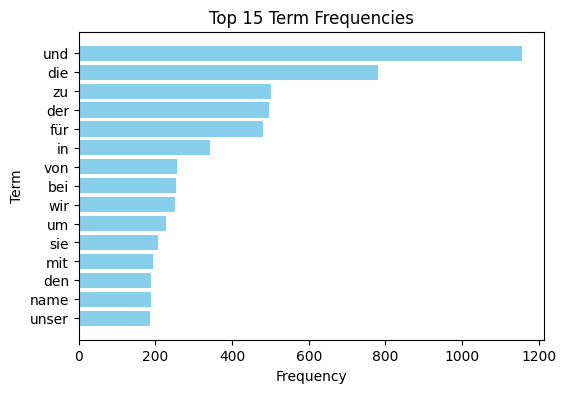

In [11]:
# Function to tokenize text into words
def simple_word_tokenize(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

# Combine content and titles
combined_texts = [title + " " + content for title, content in zip(shuffled_df["title"], shuffled_df["content"])]

# Tokenize the combined texts and calculate term frequencies
all_words = []
for text in combined_texts:
    all_words.extend(simple_word_tokenize(text))

# Calculate term frequencies
term_frequencies = Counter(all_words)

# Sort and select the top 15 most common terms
top_n = 15
top_terms = term_frequencies.most_common(top_n)

# Separate the terms and their frequencies for plotting
terms, frequencies = zip(*top_terms)

# Plot the term frequencies as a bar plot
plt.figure(figsize=(6, 4))
plt.barh(terms, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Term')
plt.title(f'Top {top_n} Term Frequencies')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top

# Display the plot
plt.show()

## Remove Duplicates

In [14]:
shuffled_df.drop_duplicates(inplace=True)

print(f'After removing duplicates, {shuffled_df.shape[0]} documents are left')

After removing duplicates, 380 documents are left


## Lexical Diversity

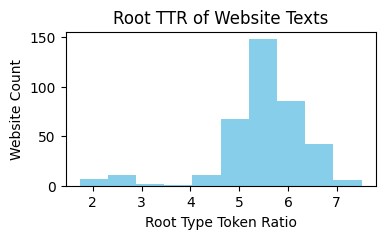

In [17]:
lex_div = shuffled_df.content.apply(ld.tokenize).apply(ld.root_ttr)

# Plotting the MSTTR values as a histogram
plt.figure(figsize=(4, 2))
plt.hist(lex_div, color='skyblue')
plt.xlabel('Root Type Token Ratio')
plt.ylabel('Website Count')
plt.title('Root TTR of Website Texts')

# Display the plot
plt.show()

In [18]:
# Filter Web documents with high Root TTR
cleaned_df = shuffled_df[lex_div>4]

cleaned_df.head(5)

,title,content
0,4. Rückblick auf die erfolgreiche Durchführung...,"[Stadt], [Datum] – Während der Pandemie wurden..."
1,3. Erweiterung der COVID-Hilfsangebote für Fam...,"[Stadt], [Datum] – Im Rahmen unserer erweitert..."
2,10. Ansprechpartner für Suchthilfe,Für Unterstützung und Beratung im Bereich der ...
4,Notfall-Blutspendeaktionen,Unser Notfall-Blutspendedienst organisiert sch...
5,Medizinische Hilfe in Krisenregionen,Unser medizinisches Hilfsprogramm ist in Krise...


In [19]:
# Removed web documents, having low value content
shuffled_df[lex_div<4].head(5)

,title,content
3,1. Willkommen auf unserer Webseite,"Entdecken Sie, was wir zu bieten haben. Wir fr..."
39,4. Newsletter-Anmeldung,Erhalten Sie die neuesten Nachrichten Bleiben ...
45,10. Kontakt,Kontaktformular Standorte Notfallkontakte Soci...
64,8. Feedback,Teilen Sie Ihre Meinung mit uns Wir freuen uns...
75,3. Besuchen Sie uns auf Social Media,Folgen Sie uns auf Facebook Besuchen Sie uns a...


## Remove Stopwords

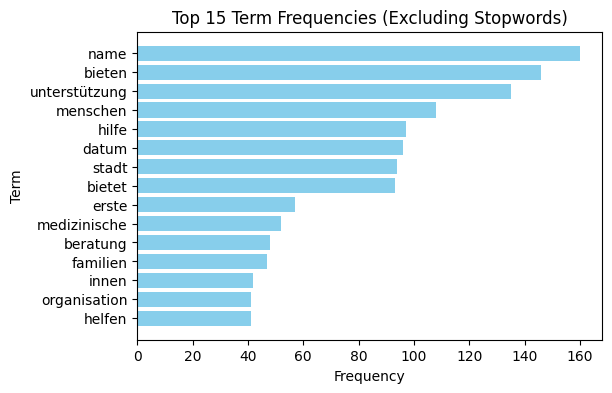

In [21]:
# List of German stopwords
german_stopwords = stopwords.words('german')

# Combine content and titles
combined_texts = [title + " " + content for title, content in zip(cleaned_df["title"], cleaned_df["content"])]

# Tokenize the combined texts and calculate term frequencies, excluding stopwords
all_words = []
for text in combined_texts:
    words = simple_word_tokenize(text)
    filtered_words = [word for word in words if word not in german_stopwords]
    all_words.extend(filtered_words)

# Calculate term frequencies
term_frequencies = Counter(all_words)

# Sort and select the top 15 most common terms
top_n = 15
top_terms = term_frequencies.most_common(top_n)

# Separate the terms and their frequencies for plotting
terms, frequencies = zip(*top_terms)

# Plot the term frequencies as a bar plot
plt.figure(figsize=(6, 4))
plt.barh(terms, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Term')
plt.title(f'Top {top_n} Term Frequencies (Excluding Stopwords)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top

# Display the plot
plt.show()

# Processing

## Anonymization with Entity Recognition

The synthetic dataset has been prepared upfront with making sure not to contain personal identifable information.

## Train Social Service Classifier

In [22]:
! pip install weasel -q

## Homeless Relief

## Social Services

# Data Applications

## Keyword Search

## Semantic Search

## Creating a Map